# Introduction

So what we have is 1 second long samples of people saying some specific words, recorded with a large variety of devices in diverse conditions to get as many different types of input samples as possible. We aim to train a deep learning classifier in order to correctly classify the words in to the correct label. The data has been taken from the Kaggle competition [TensorFlow Speech Recognition Challenge]('https:\\\\www.kaggle.com\\competitions\\tensorflow-speech-recognition-challenge\\overview').

However we deviate slightly from the competition guidelines and rather predict the correct labels for all the classes. Moreoever, we restrict our overall classification to only 10 classes - "zero", "one", "two", ... , "nine".

# Extraction of data

At first we extract the .7z archives into *`kaggle\\working\\`*.

In [ ]:
!pip install py7zr
import py7zr
archive=py7zr.SevenZipFile('..\\input\\tensorflow-speech-recognition-challenge\\train.7z', mode='r')
archive.extractall(path="\\kaggle\\working")
archive.close()
# archive=py7zr.SevenZipFile('..\\input\\tensorflow-speech-recognition-challenge\\test.7z', mode='r')
# archive.extractall(path="\\kaggle\\working")
# archive.close()

In [24]:
# we remove the background noise folder
!rm -rf \\kaggle\\working\\train\\audio\\_background_noise_

# Imports

In [1]:
import os
import shutil
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
cwd = os.getcwd()

In [3]:
# torch imports

import torch
from torch.utils.data import Dataset
import torchaudio

# File structure

Below are the categories for which we have audio samples, and then after that will be number of audio sample for each class

In [72]:
CLASSES = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine"
]

for sound in CLASSES:
    if sound != '_background_noise_': # because that is not a category that we will be predicting for
        path = os.path.join(cwd, "train", "audio", sound)
        print(f"Number of samples in {sound} is {len(os.listdir(path))}")

Number of samples in zero is 2376
Number of samples in one is 2370
Number of samples in two is 2373
Number of samples in three is 2356
Number of samples in four is 2372
Number of samples in five is 2357
Number of samples in six is 2369
Number of samples in seven is 2377
Number of samples in eight is 2352
Number of samples in nine is 2364


# Preparing the dataset

## Gathering the train, test and val samples

In the zipped files, we have the files `testing_list.txt` and `validation_list.txt` which contains the full file path of the audio files which are to be in training and validation sets respectively. So we read those paths and store them. 

In [117]:
test = pd.DataFrame(
    open(os.path.join(cwd, "train", "testing_list.txt"), 'r').readlines(),
).apply(lambda row: os.path.join(cwd, "train", "audio", os.sep.join(row[0].split('\n')[0].split('/'))), axis=1)
validation = pd.DataFrame(
    open(os.path.join(cwd, "train", "validation_list.txt"), 'r').readlines(),
).apply(lambda row: os.path.join(cwd, "train", "audio", os.sep.join(row[0].split('\n')[0].split('/'))), axis=1)

Since we have the test and val sets, we should also have the train set as well

In [118]:
all_files = set(glob.glob(os.path.join(cwd, "train", "audio", "*", "*.wav")))
train = pd.Series(
    list(all_files - set(test.values) - set(validation.values))
)
# train = train[train.apply(lambda x: False if x.split('\\')[3] == '_background_noise_' else True)]

We run into a problem here: each of train, val, test contains unwanted classes. We remove them.

In [119]:
def remove_unwanted_classes(dataset, classes):
    return dataset[dataset.apply(lambda x: True if x.split(os.sep)[5] in classes else False)].reset_index(drop=True)

train = remove_unwanted_classes(train, CLASSES)
validation = remove_unwanted_classes(validation, CLASSES)
test = remove_unwanted_classes(test, CLASSES)

We see the number of samples from each category in each of the train, val and test sets and also the total number of samples in each of them.

In [120]:
print(
    pd.DataFrame(
        {
            '#train': pd.concat([train.apply(lambda x: x.split(os.sep)[5]).value_counts(), pd.Series({'total': len(train)})]),
            '#validation': pd.concat([validation.apply(lambda x: x.split(os.sep)[5]).value_counts(), pd.Series({'total': len(validation)})]),
            '#test': pd.concat([test.apply(lambda x: x.split(os.sep)[5]).value_counts(), pd.Series({'total': len(test)})]),
        },
        index = CLASSES + ['total']
    )
)

       #train  #validation  #test
zero     1866          260    250
one      1892          230    248
two      1873          236    264
three    1841          248    267
four     1839          280    253
five     1844          242    271
six      1863          262    244
seven    1875          263    239
eight    1852          243    257
nine     1875          230    259
total   18620         2494   2552


Finally we we need to make a train, test, and val dataset, with the file path and the corressponding labels. We also will need to create a `CLASS_MAPPING` where we map the integer labels to the actual labels.

In [88]:
# maps class to label
LABEL_MAPPING = {text_label: int_label for int_label, text_label in enumerate(CLASSES)}
# maps label to clsss
CLASS_MAPPING = {int_label: text_label for int_label, text_label in enumerate(CLASSES)}

In [90]:
def convert_to_annoted_dataframe(dataset, label_mapping):
    dataset = pd.DataFrame(dataset, columns=['path'])
    dataset['class'] = dataset['path'].apply(lambda p: p.split(os.sep)[5])
    dataset['label'] = dataset['class'].map(LABEL_MAPPING)
    return dataset

train = convert_to_annoted_dataframe(train, LABEL_MAPPING)
validation = convert_to_annoted_dataframe(validation, LABEL_MAPPING)
test = convert_to_annoted_dataframe(test, LABEL_MAPPING)

## Creating a data loader

In [93]:
# constants

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
AUDIO_DIR = os.path.join(cwd, "train", "audio")

In [94]:
class SpeechData(Dataset):
    
    def __init__(self, annotations_file, audio_dir):
        """
        annotations_file: dataframe containing the file paths and the labels of whichever dataset we are loading
        audio_dir: directory where the audio files are located (assuming that _background_noise_ has been deleted)
        """
        self.annotations_file = annotations_file
        self.audio_dir = audio_dir
        
    def __len__(self):
        """
        returns: len(data)
        """
        return len(self.annotations_file)
    
    def __getitem__(self, index):
        """
        returns: data[index] -> torch.tensor(signal, label)
        """
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sample_rate = torchaudio.load(audio_sample_path)
        return signal, label, sample_rate
    
    def _get_audio_sample_path(self, index):
        return self.annotations_file.loc[index, 'path']
    
    def _get_audio_sample_label(self, index):
        return self.annotations_file.loc[index, 'label']

In [95]:
audio = SpeechData(train, AUDIO_DIR)
print(f"There are {len(audio)} samples")

There are 18620 samples


In [107]:
signal, label, sample_rate = audio[45]
print(f"Signal shape: {signal.shape} # (num_channels, num_samples)")
print(f"Label: {label}")
print(f"Class: {CLASS_MAPPING[label]}")
print(f"Sample Rate: {sample_rate}")

Signal shape: torch.Size([1, 16000]) # (num_channels, num_samples)
Label: 7
Class: seven
Sample Rate: 16000


## Audio files, signals, channels and sample rates

The audio files are all 1 second long and are in the *.int* format. The audio signals that `torchaudio` returns us are `tensors` in the shape of `(num_channels, num_samples)`.  

- `num_channels` will be 1 or 2 depending on whether the audio is **mono** or **stereo**. In case it is in stereo, we will downmix it to a mono channel. Generally we do this by taking the average of the samples in both the channels at the same time stamps.  
- `num_samples` is the total number of samples present in the audio.  
- `sample_rate` is the number of samples in 1 second of the audio. Since in our data we have only 1 second long audio, our `num_samples` = `sample_rate`. Generally we have a target sample rate that we will use with `torchaudio`. In order to get to that target sample rate we may have to resample the audio if necessary.  

In our dataset, all our audio are mono and sampled at 16000 samples per second. This means we dont have to unnecessarily work on resizing or resampling.

In [108]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(14, 10))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False);

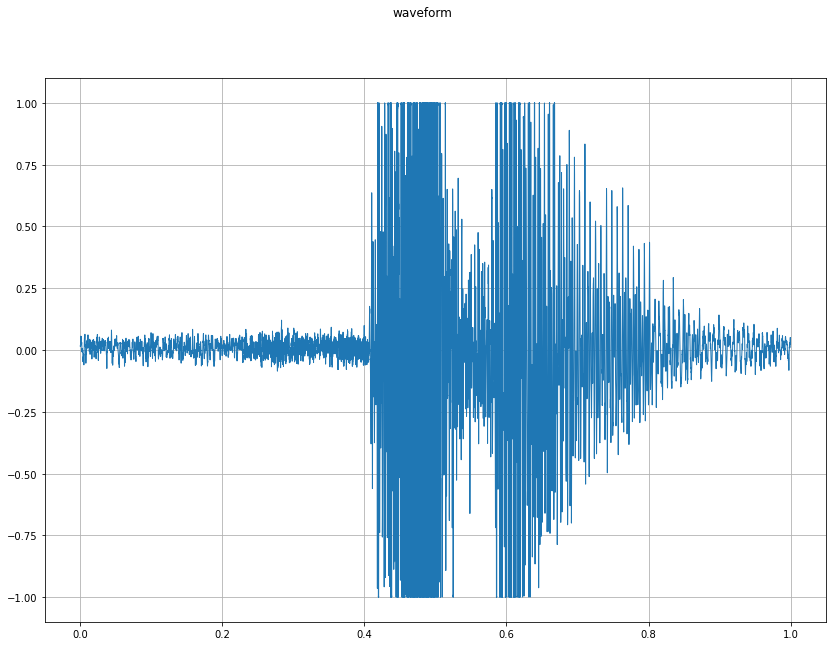

In [109]:
plot_waveform(signal, sample_rate)